In [1]:
import numpy as np
import gpstk
from GNSS_TK1 import *
import matplotlib.pyplot as plt
%matplotlib inline

Funciones

In [5]:
stations=[[["data/zob1324.03.n","data/zob13240.03o"],["data/garf324.03.n","data/garf3240.03o"]],[["data/woos324.03.n","data/woos324.03.o"],["data/garf324.03.n","data/garf3240.03o"]]]
#

In [10]:
def gradients(stations):
    for pair in stations:
        st1=pair[0]
        st2=pair[1]
        print "Station 1:",st1
        print "\nStation 2:",st2
        t1,t2,Icode1,Iphase1,Icode2,Iphase2,VTECphase1,VTECphase2,ELEV1,ELEV2,IPP1,IPP2,L11,L12,L21,L22=getdata_stationpair(st1,st2,"GPS 8")
        obs1=get_arcs(t1,Icode1,Iphase1,ELEV1,IPP1,L11,L12) #gets Phase, Code, and adjusted times 
        obs2=get_arcs(t2,Icode2,Iphase2,ELEV2,IPP2,L21,L22)

        for arc in range(len(obs1)):#to each arc observed in a day
            print "*************Arc "+str(arc+1)+"*************"
            time1=obs1[arc][0] #times on station 1 same arc!
            time2=obs2[arc][0] #times on station 2

            tboth=np.intersect1d(time1,time2)
            print "\nTimes in common: ",tboth.size

            #Now we take observations in both stations
            t1index=np.array([i for i in range(time1.size) if time1[i] in tboth ])
            t2index=np.array([i for i in range(time2.size) if time2[i] in tboth ])

            time1=time1[t1index] #times on station 1 same arc!
            time2=time2[t2index]

            Phase1=obs1[arc][1][t1index]
            Phase2=obs2[arc][1][t2index]

            Code1=obs1[arc][2][t1index]
            Code2=obs2[arc][2][t2index]

            Elevation1=obs1[arc][3][t1index]
            Elevation2=obs2[arc][3][t2index]

            #Phase on frequency L1 on stations 1 and 2
            L11=obs1[arc][4][t1index]
            L12=obs1[arc][5][t1index]

            #Phase on frequency L2 on stations 1 and 2
            L21=obs2[arc][4][t2index]
            L22=obs2[arc][5][t2index]

            #Detect data jumps on L1-L2
            jumps1=datajump(Phase1,time1,2.5)
            print "\nData Jumps st1: ",jumps1
            print time1[jumps1]/3600

            jumps2=datajump(Phase2,time2,2.5)
            print "\nData Jumps st2: ",jumps2,"\n\n"
            print time1[jumps2]/3600

            #Divide in Sub-arcs using jumps
            print "Divide in Sub-arcs using jumps"
            miniarcs1=sub_arcs(Phase1,jumps1)
            miniarcs2=sub_arcs(Phase2,jumps2)
            #print "\nSubarcs st1: ",miniarcs1
            #print "\nSubarcs st2: ",miniarcs2

            #Remove short arcs 
            print "\nRemove short arcs"
            if len(jumps1)>0:
                miniarcs1,miniarcs2=remove_short(miniarcs1,miniarcs2)
            if len(jumps2)>0:
                miniarcs2,miniarcs1=remove_short(miniarcs2,miniarcs1)

            #Polinomial fit and Outlier Detection
            ##On each subarc check for slips and delete.
            pslips1=[] #slips in st1 with polinomyal fit
            pslips2=[] #slips in st2 with polinomyal fit
            oslips1=[] #slips in st1 oulier factor
            oslips2=[] #slips in st2 oulier factor

            for i in range(len(miniarcs1)):#In station1
                __,pslip=poly_fit(Phase1[miniarcs1[i]],time1[miniarcs1[i]])
                pslips1.append(pslip)
                __,oslip=outlier_detect(Phase1[miniarcs1[i]],time1[miniarcs1[i]]*3600)
                oslips1.append(oslip)

            for i in range(len(miniarcs2)):#In station2
                __,pslip=poly_fit(Phase2[miniarcs2[i]],time2[miniarcs2[i]])
                pslips2.append(pslip)
                __,oslip=outlier_detect(Phase2[miniarcs2[i]],time2[miniarcs2[i]]*3600)
                oslips2.append(oslip)

            ##Using polinompyal fit and outlier factor methods we confirm slips
            confirmed1=[] #a list of lists with the confirmed outliers on each subarc
            confirmed2=[]

            for i in range(len(miniarcs1)):
                outliers=confirmed_slip(time1[miniarcs1[i]],Phase1[miniarcs1[i]])
                confirmed1.append(outliers)

            for i in range(len(miniarcs2)):
                outliers=confirmed_slip(time2[miniarcs2[i]],Phase2[miniarcs2[i]])
                confirmed2.append(outliers) 

            #Remove slips from both stations
            for i in range(len(confirmed1)):
                if len(confirmed1[i])!=0:
                    miniarcs1[i],miniarcs2=remove_slip(miniarcs1[i],miniarcs2,oslips1[i])

            for i in range(len(confirmed2)):
                if len(confirmed2[i])!=0:
                    miniarcs2[i],miniarcs1=remove_slip(miniarcs2[i],miniarcs1,oslips2[i])
            
            
            
            
            #Leveling Phase

            PhaseArc1=[] #list with subarcs leveled
            PhaseArc2=[]
            C1,C2=[],[]
            PhaseL11,PhaseL12=[],[]
            PhaseL21,PhaseL22=[],[]
            
            #plt.figure(figsize=(16,10))

            for i in range(len(miniarcs1)):
                Lfactor,new_IPHASE_arc=levelphase(Code1[miniarcs1[i]],Phase1[miniarcs1[i]],Elevation1[miniarcs1[i]])
                PhaseArc1.append(new_IPHASE_arc)  
                C1.append(Code1[miniarcs1[i]])
                PhaseL11.append(L11[miniarcs1[i]])
                PhaseL12.append(L12[miniarcs1[i]])
                #plt.subplot(1,len(miniarcs1),i)
                #title="Arc ",str(arc+1)," Subarc ",str(i+1)," Station 1"
                #plt.title(title)
                #plt.scatter(time1[miniarcs1[i]]/3600,new_IPHASE_arc)
                
            
             
            #plt.figure(figsize=(16,10))
            
            for i in range(len(miniarcs2)):
                Lfactor,new_IPHASE_arc=levelphase(Code2[miniarcs2[i]],Phase2[miniarcs2[i]],Elevation2[miniarcs2[i]])
                PhaseArc2.append(new_IPHASE_arc)
                C2.append(Code2[miniarcs2[i]])
                PhaseL21.append(L21[miniarcs2[i]])
                PhaseL22.append(L22[miniarcs2[i]])
                #plt.subplot(1,len(miniarcs2),i)
                #title="Arc ",str(arc+1),"Subarc ",str(i+1)," Station 2"
                #plt.title(title)
                #plt.scatter(time2[miniarcs2[i]]/3600,new_IPHASE_arc)
                
                
            new_IPHASE_arc1=np.hstack(PhaseArc1) 
            new_IPHASE_arc2=np.hstack(PhaseArc2)
            C1=np.hstack(C1)
            C2=np.hstack(C2)
            L11=np.hstack(PhaseL11)
            L12=np.hstack(PhaseL12)
            L21=np.hstack(PhaseL21)
            L22=np.hstack(PhaseL22)


            ntimes1=np.array([])
            ntimes2=np.array([])
            

            for i in miniarcs1:
                ntimes1=np.append(ntimes1,time1[i])

            for i in miniarcs2:
                ntimes2=np.append(ntimes2,time2[i])
            print "# Observations st1: ",ntimes1.size,new_IPHASE_arc1.size
            print "# Observations st2: ",ntimes2.size,new_IPHASE_arc2.size


            plt.figure(figsize=(16,10))

            plt.subplot(4,3,1)
            title="For arc #"+str(arc+1)+"Station 1 Phase"
            plt.title(title)
            plt.scatter(ntimes1/3600,new_IPHASE_arc1,color="blue")

            plt.subplot(4,3,2)
            title="For arc #"+str(arc+1)+"Station 2 Phase"
            plt.title(title)
            plt.scatter(ntimes2/3600,new_IPHASE_arc2,color="blue")

            plt.subplot(4,3,3)
            title="Gradient Phase"
            plt.title(title)
            plt.scatter(ntimes2/3600,new_IPHASE_arc1-new_IPHASE_arc2,color="red")

            plt.subplot(4,3,4)
            title="For arc #"+str(arc+1)+"Station 1 Code"
            plt.title(title)
            plt.scatter(ntimes1/3600,C1,color="green")

            plt.subplot(4,3,5)
            title="For arc #"+str(arc+1)+"Station 2 Code"
            plt.title(title)
            plt.scatter(ntimes2/3600,C2,color="green")

            plt.subplot(4,3,6)
            title="Gradient Code"
            plt.title(title)
            plt.scatter(ntimes2/3600,C1-C2,color="red")

            plt.subplot(4,3,7)
            title="Phase L1 arc #"+str(arc+1)+"Station 1"
            plt.title(title)
            #plt.xlim(18,20)
            plt.scatter(ntimes2/3600,L11,color="red")

            plt.subplot(4,3,8)
            title="Phase L2 arc #"+str(arc+1)+"Station 1"
            plt.title(title)
            #plt.xlim(18,20)
            plt.scatter(ntimes2/3600,L12,color="red")

            plt.subplot(4,3,10)
            title="Phase L1 arc #"+str(arc+1)+"Station 2"
            plt.title(title)
            #plt.xlim(18,20)
            plt.scatter(ntimes2/3600,L21,color="red")


            plt.subplot(4,3,11)
            title="Phase L2 arc #"+str(arc+1)+"Station 2"
            plt.title(title)
            #plt.xlim(18,20)
            plt.scatter(ntimes2/3600,L21,color="red")




Station 1: ['data/zob1324.03.n', 'data/zob13240.03o']

Station 2: ['data/garf324.03.n', 'data/garf3240.03o']
*************Arc 1*************

Times in common:  108

Data Jumps st1:  [0]
[ 5.70833333]

Data Jumps st2:  [0 1] 


[ 5.70833333  5.71666667]
Divide in Sub-arcs using jumps

Remove short arcs
SubArc #  0  Has  0  points
Sub-Arcs deleted 0 []
SubArc #  1  Has  108  points

Deleted elements on the other station:  {}

New # of subarcs arc1:  1

New # of subarcs of arc2 (other station):  3
SubArc #  0  Has  0  points
Sub-Arcs deleted 0 []
SubArc #  1  Has  1  points
Sub-Arcs deleted 1 [0]
SubArc #  2  Has  107  points

Deleted elements on the other station:  {0: [0]}

New # of subarcs arc1:  1

New # of subarcs of arc2 (other station):  1
# Observations st1:  107 107
# Observations st2:  107 107
*************Arc 2*************

Times in common:  632

Data Jumps st1:  [  0 148 168 169 177 179 375 376 377 378]
[ 17.875       19.10833333  19.275       19.28333333  19.35        19.366

/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


{0: [0, 1, 2, 3], 1: [18, 19], 2: [188, 189, 190, 191]}

New # of subarcs arc1:  3

New # of subarcs of arc2 (other station):  4
# Observations st1:  608 608
# Observations st2:  608 608
Station 1: ['data/woos324.03.n', 'data/woos324.03.o']

Station 2: ['data/garf324.03.n', 'data/garf3240.03o']
*************Arc 1*************

Times in common:  82

Data Jumps st1:  [ 1  4  6 80 81]
[ 5.80833333  5.83333333  5.85833333  6.475       6.48333333]

Data Jumps st2:  [0] 


[ 5.8]
Divide in Sub-arcs using jumps

Remove short arcs
SubArc #  0  Has  1  points
Sub-Arcs deleted 0 [0]
SubArc #  1  Has  3  points
Sub-Arcs deleted 1 [1 2 3]
SubArc #  2  Has  2  points
Sub-Arcs deleted 2 [4 5]
SubArc #  3  Has  74  points
SubArc #  4  Has  1  points
Sub-Arcs deleted 4 [80]
SubArc #  5  Has  1  points
Sub-Arcs deleted 5 [81]

Deleted elements on the other station:  {1: [0, 1, 2, 3, 4, 5, 80, 81]}

New # of subarcs arc1:  1

New # of subarcs of arc2 (other station):  2
SubArc #  0  Has  0  points
Sub-A

/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)




Times in common:  637

Data Jumps st1:  [  0   1 377 378 379]
[ 17.875       17.88333333  21.01666667  21.025       21.03333333]

Data Jumps st2:  [  0   1   3   4 166 167 168 368 369 370 371 372] 


[ 17.875       17.88333333  17.9         17.90833333  19.25833333
  19.26666667  19.275       20.94166667  20.95        20.95833333
  20.96666667  20.975     ]
Divide in Sub-arcs using jumps

Remove short arcs
SubArc #  0  Has  0  points
Sub-Arcs deleted 0 []
SubArc #  1  Has  1  points
Sub-Arcs deleted 1 [0]
SubArc #  2  Has  376  points
SubArc #  3  Has  1  points
Sub-Arcs deleted 3 [377]
SubArc #  4  Has  1  points
Sub-Arcs deleted 4 [378]
SubArc #  5  Has  258  points

Deleted elements on the other station:  {1: [0], 12: [5, 6]}

New # of subarcs arc1:  2

New # of subarcs of arc2 (other station):  13
SubArc #  0  Has  0  points
Sub-Arcs deleted 0 []
SubArc #  1  Has  0  points
Sub-Arcs deleted 1 []
SubArc #  2  Has  2  points
Sub-Arcs deleted 2 [1 2]
SubArc #  3  Has  1  points
Sub-

/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


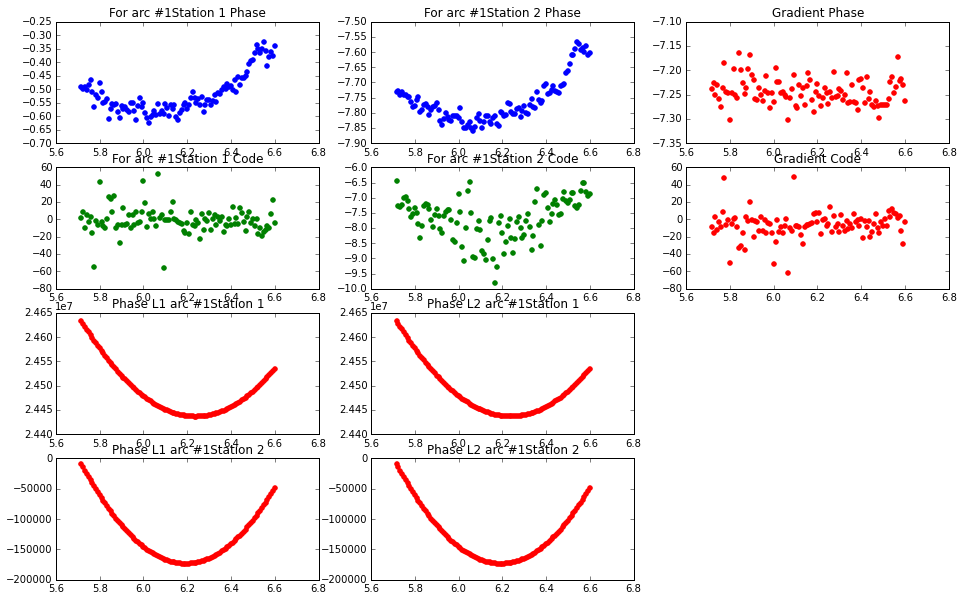

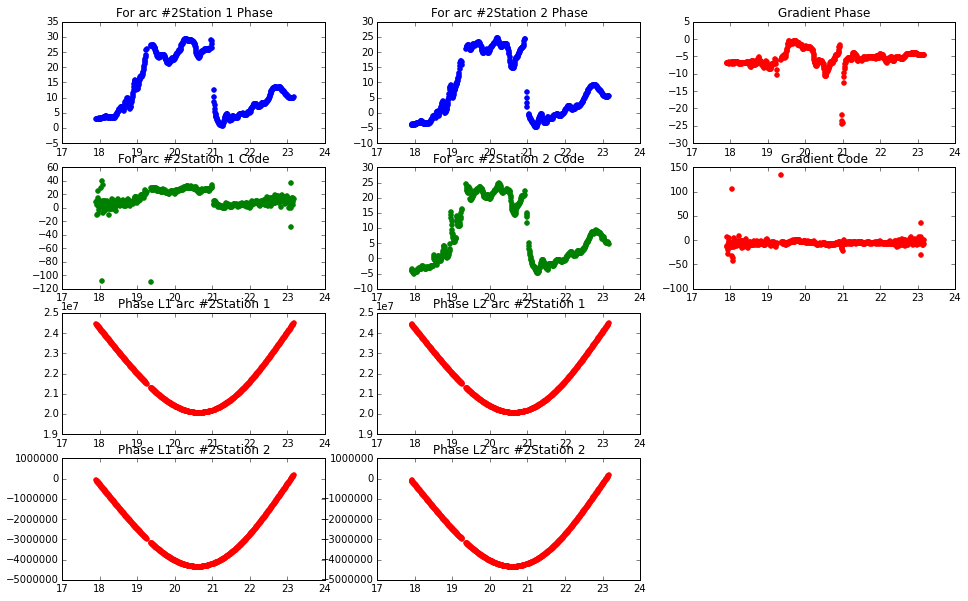

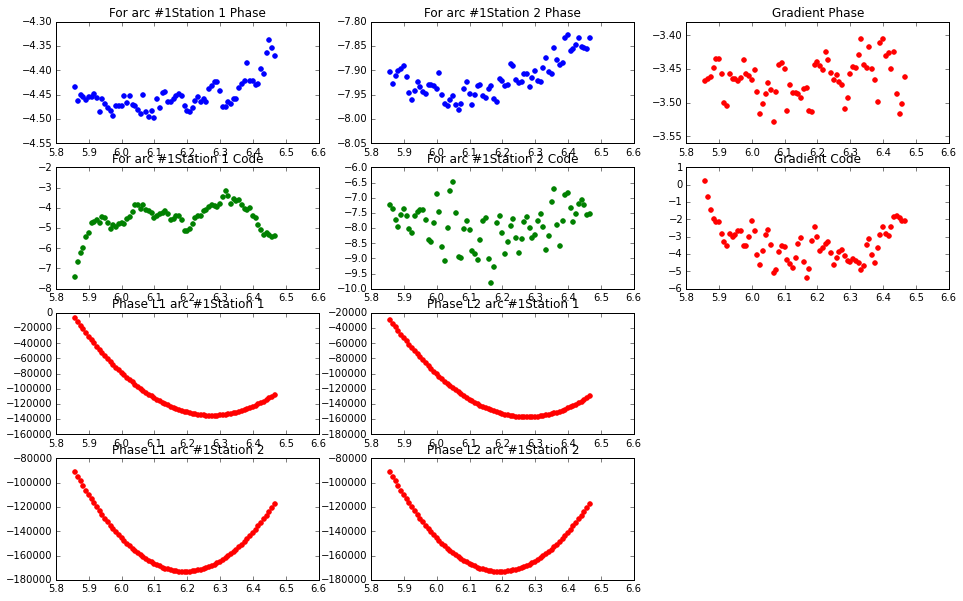

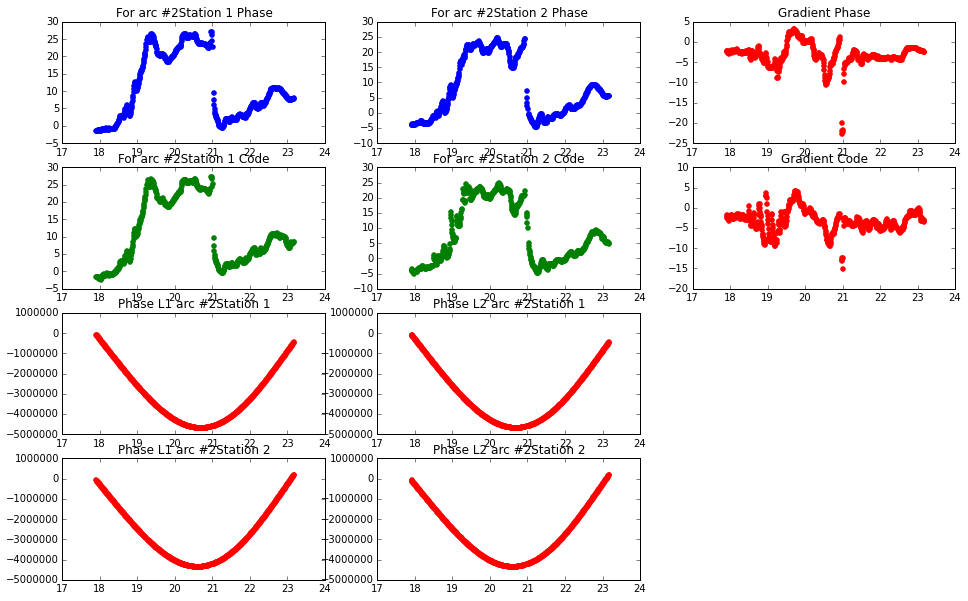

In [11]:
gradients(stations)